In [241]:
#import importatnt packages 
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import accuracy_score, plot_confusion_matrix,plot_roc_curve, confusion_matrix 
import matplotlib.pyplot as plt 

# The Natural Language Toolkit, or more commonly NLTK, is a suite of libraries and programs for symbolic and 
# statistical natural language processing for English written in the Python programming language.
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re

#TQDM is a progress bar library with good support for nested loops and Jupyter/IPython notebooks.
from tqdm import tqdm

import warnings 
warnings.filterwarnings("ignore")
np.random.seed(123)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DAVIS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DAVIS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [242]:
# load dataset 
data = pd.read_csv("data/train.tsv", sep='\t')    


In [243]:
#check data shape
data.shape 

(156060, 4)

In [244]:
# show data columns 
data.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')

In [245]:
# show the firt five rows
data.head(5) 


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [246]:
# data information 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [247]:
#sohw single phrase 
data['Phrase'][:1]

0    A series of escapades demonstrating the adage ...
Name: Phrase, dtype: object

In [248]:
# check if you have missing values 
data.isnull().sum() 

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

We dont have any missing values 

### Use only the 1 star and 5 star reviews¶
For this example, we want to only predict positive or negative sentiment using the extreme cases.

In [249]:
data.Sentiment.value_counts() 

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [250]:
data_pos_neg = data[(data['Sentiment'] == 0) | (data['Sentiment'] == 4)]

In [251]:
## Relabel as 0 for negative and 1 for positive
data_pos_neg['Binary'] = data_pos_neg.apply(
    lambda x: 0 if x['Sentiment'] == 0 else 1, axis=1)

In [252]:
#show first five rows after filtering 
data_pos_neg.head()

,PhraseId,SentenceId,Phrase,Sentiment,Binary
63,64,2,"This quiet , introspective and entertaining in...",4,1
66,67,2,"quiet , introspective and entertaining indepen...",4,1
74,75,2,entertaining,4,1
77,78,2,is worth seeking,4,1
101,102,3,would have a hard time sitting through this one,0,0


### Function for cleaning the reviews
This function will take each phrase iteratively and it will

- remove html content
- remove non-alphabetic characters

In [253]:
def clean_sentences(df):

    for sent in tqdm(df['Phrase']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        
        #replacce in the dataframe 
        df.replace(to_replace = sent, value = review_text.lower()) 

    return(df)

In [254]:
# let clean the dataset 
train_sentences  = clean_sentences(data_pos_neg)

100%|██████████| 16278/16278 [06:59<00:00, 38.76it/s]


In [255]:
# create a class to lemmatize the phrase 

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, phrase):
        return [self.wnl.lemmatize(t) for t in word_tokenize(phrase)]

In [256]:
# create the trasform and add LemmaTokenizer 

vectorizer = TfidfVectorizer(tokenizer= LemmaTokenizer())

In [257]:
# fit the vectorizer 

vectorizer.fit(train_sentences.loc[:,'Phrase'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<__main__.LemmaTokenizer object at 0x000001E845BF8D68>,
                use_idf=True, vocabulary=None)

In [258]:
#check list of vocabulary 

vectorizer.vocabulary_ 

{'this': 9285,
 'quiet': 7258,
 ',': 20,
 'introspective': 4896,
 'and': 477,
 'entertaining': 3067,
 'independent': 4711,
 'is': 4949,
 'worth': 10365,
 'seeking': 8035,
 '.': 25,
 'would': 10369,
 'have': 4258,
 'a': 159,
 'hard': 4220,
 'time': 9342,
 'sitting': 8339,
 'through': 9315,
 'one': 6368,
 'positively': 6973,
 'thrilling': 9309,
 'combination': 1761,
 'of': 6324,
 'ethnography': 3138,
 'all': 388,
 'the': 9243,
 'intrigue': 4891,
 'betrayal': 953,
 'deceit': 2285,
 'murder': 6038,
 'shakespearean': 8184,
 'tragedy': 9450,
 'or': 6414,
 'juicy': 5072,
 'soap': 8481,
 'opera': 6393,
 'aggressive': 343,
 'self-glorification': 8072,
 'manipulative': 5631,
 'whitewash': 10235,
 'comedy-drama': 1771,
 'nearly': 6132,
 'epic': 3088,
 'proportion': 7148,
 'rooted': 7761,
 'in': 4668,
 'sincere': 8318,
 'performance': 6721,
 'by': 1305,
 'title': 9364,
 'character': 1496,
 'undergoing': 9697,
 'midlife': 5827,
 'crisis': 2114,
 'trouble': 9536,
 'every': 3166,
 'day': 2250,
 'plod

In [261]:
#check length of vocabulary

len(vectorizer.vocabulary_)

10462

In [262]:
print("IDF: {}".format(vectorizer.idf_))

IDF: [6.98405915 8.29973594 7.86441787 ... 9.59901892 9.59901892 8.90587174]


In [263]:
#transform the text data 

X = vectorizer.transform(train_sentences.loc[:, 'Phrase'])

In [264]:
#separate target from data 

y = train_sentences.loc[:, 'Binary']

In [265]:
#split test and train

X_train, X_test, y_train, y_test = train_test_split(X, y,)

In [266]:
#import classifier 

from sklearn.linear_model import LogisticRegression, RidgeClassifier 


In [267]:
#train the classifier

model = LogisticRegression() 
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [268]:
preds = model.predict(X_test)

print(accuracy_score(preds,y_test))

0.927027027027027


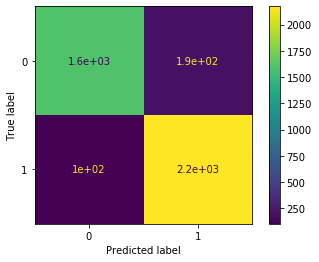

In [269]:
# draw a confusion matrix 

plot_confusion_matrix(model,X_test,y_test) 

In [270]:
confusion_matrix(preds,y_test)

array([[1600,  104],
       [ 193, 2173]], dtype=int64)

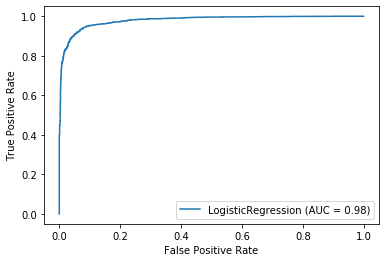

In [271]:
#draw roc_curve

plot_roc_curve(model, X_test, y_test) 